# 1. 모델 불러오기

In [ ]:
import torch
from torch import nn
from transformers import AutoFeatureExtractor, AutoTokenizer, AutoModel

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# CLIP과 KoBERT 모델 불러오기
vit_model = AutoModel.from_pretrained("google/vit-base-patch16-224").to(device)
vit_processor = AutoFeatureExtractor.from_pretrained("google/vit-base-patch16-224")
kobert_model = AutoModel.from_pretrained("monologg/kobert").to(device)
kobert_tokenizer = AutoTokenizer.from_pretrained("monologg/kobert")


for param in kobert_model.parameters():
    param.requires_grad = False

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/69.7k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


config.json:   0%|          | 0.00/426 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/369M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/263 [00:00<?, ?B/s]

The repository for monologg/kobert contains custom code which must be executed to correctly load the model. You can inspect the repository content at https://hf.co/monologg/kobert.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N] y


tokenization_kobert.py:   0%|          | 0.00/10.9k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/monologg/kobert:
- tokenization_kobert.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


tokenizer_78b3253a26.model:   0%|          | 0.00/371k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/77.8k [00:00<?, ?B/s]

In [ ]:
# text model encoder output

text = "안녕하세요, GPT-4입니다."
text_inputs = kobert_tokenizer(text, return_tensors="pt").to(device)
text_outputs = kobert_model(**text_inputs)

text_last_hidden_state = text_outputs.last_hidden_state
text_pooled_output = text_outputs.pooler_output

print(text_last_hidden_state.shape)
print(text_pooled_output.shape)

torch.Size([1, 12, 768])
torch.Size([1, 768])


In [ ]:
from PIL import Image
import requests
from transformers import AutoProcessor, CLIPVisionModel

# image model encoder output
url = "http://images.cocodataset.org/val2017/000000039769.jpg"
image = Image.open(requests.get(url, stream=True).raw)

image_inputs = vit_processor(images=image, return_tensors="pt").pixel_values.to(device)

image_outputs = vit_model(image_inputs)
image_last_hidden_state = image_outputs.last_hidden_state
image_pooled_output = image_outputs.pooler_output  # pooled CLS states

print(image_last_hidden_state.shape)
print(image_pooled_output.shape)

torch.Size([1, 197, 768])
torch.Size([1, 768])


In [ ]:
image_inputs.shape

torch.Size([1, 3, 224, 224])

# 2. Dataset & DataLoader

In [ ]:
from google.colab import files
files.upload()  # kaggle.json 파일 업로드

# 이거 각자 kaggle account에서 Create API token해서 다운로드해서 여기 업로드한 후 진행

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"matildabae0314","key":"7d64cd89e249480256ffddd1f48d98f9"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# Affectnet
!kaggle datasets download -d mstjebashazida/affectnet

# 압축 해제
import zipfile

with zipfile.ZipFile('affectnet.zip', 'r') as zip_ref:
    zip_ref.extractall('affectnet')



Dataset URL: https://www.kaggle.com/datasets/mstjebashazida/affectnet
License(s): MIT
 98% 317M/324M [00:01<00:00, 213MB/s]
100% 324M/324M [00:01<00:00, 186MB/s]


In [ ]:
import os
import shutil

# 폴더 경로 설정
affectnet_path = '/content/affectnet/archive (3)'

# 1. Contempt 폴더 삭제
contempt_path = os.path.join(affectnet_path, 'Test', 'Contempt')
if os.path.exists(contempt_path):
    shutil.rmtree(contempt_path)

# 2. Anger 폴더 이름 변경
anger_path = os.path.join(affectnet_path, 'Test', 'Anger')
new_anger_path = os.path.join(affectnet_path, 'Test', 'anger')
os.rename(anger_path, new_anger_path)

# 3. 폴더 생성 및 이미지 이동
def move_images(src_folder, dst_folder):
    if not os.path.exists(dst_folder):
        os.makedirs(dst_folder)
    for category in ['anger', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']:
        src_category = os.path.join(src_folder, category)
        dst_category = os.path.join(dst_folder, category)
        if os.path.exists(src_category):
            if not os.path.exists(dst_category):
                os.makedirs(dst_category)
            for file_name in os.listdir(src_category):
                src_file = os.path.join(src_category, file_name)
                dst_file = os.path.join(dst_category, file_name)
                shutil.move(src_file, dst_file)

# Test 및 Train 폴더 처리
content_data_path = '/content/data'
os.makedirs(content_data_path, exist_ok=True)

for folder in ['Test', 'Train']:
    folder_path = os.path.join(affectnet_path, folder)
    move_images(folder_path, content_data_path)


In [ ]:
# 데이터 폴더 내 이미지 개수 출력
def count_files_in_folder(folder_path):
    return sum([len(files) for r, d, files in os.walk(folder_path)])

print("Number of images in content/data:")
for category in ['anger', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']:
    folder_path = os.path.join(content_data_path, category)
    print(f"{category}: {count_files_in_folder(folder_path)}")

Number of images in content/data:
anger: 3218
disgust: 2477
fear: 3176
happy: 5044
neutral: 5126
sad: 3091
surprise: 4039


In [ ]:
# FER-2013
!kaggle datasets download -d astraszab/facial-expression-dataset-image-folders-fer2013

# 압축 해제
with zipfile.ZipFile('facial-expression-dataset-image-folders-fer2013.zip', 'r') as zip_ref:
    zip_ref.extractall('fer2013')


Dataset URL: https://www.kaggle.com/datasets/astraszab/facial-expression-dataset-image-folders-fer2013
License(s): unknown
 83% 54.0M/65.1M [00:00<00:00, 197MB/s]
100% 65.1M/65.1M [00:00<00:00, 194MB/s]


In [ ]:
# FER-2013 폴더 경로 설정
fer2013_path = '/content/fer2013/data'
emotion_map = {
    '0': 'anger',
    '1': 'disgust',
    '2': 'fear',
    '3': 'happy',
    '4': 'sad',
    '5': 'surprise',
    '6': 'neutral'
}

def rename_folders(base_path):
    for subset in ['test', 'train', 'val']:
        subset_path = os.path.join(base_path, subset)
        for num, emotion in emotion_map.items():
            num_folder = os.path.join(subset_path, num)
            emotion_folder = os.path.join(subset_path, emotion)
            if os.path.exists(num_folder):
                os.rename(num_folder, emotion_folder)

def move_fer2013_images(base_path, target_path):
    for subset in ['test', 'train', 'val']:
        subset_path = os.path.join(base_path, subset)
        move_images(subset_path, target_path)

# 폴더 이름 변경
rename_folders(fer2013_path)

# FER-2013 이미지를 content/data로 이동
move_fer2013_images(fer2013_path, content_data_path)


In [ ]:
# 데이터 폴더 내 이미지 개수 출력 최종 !!!
print("Number of images in content/data after FER-2013 merge:")
for category in ['anger', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']:
    folder_path = os.path.join(content_data_path, category)
    print(f"{category}: {count_files_in_folder(folder_path)}")

Number of images in content/data after FER-2013 merge:
anger: 8171
disgust: 3024
fear: 8297
happy: 14033
neutral: 11324
sad: 9168
surprise: 8041


In [ ]:
# 폴더와 파일 경로 설정
affectnet_folder = '/content/affectnet'
fer2013_folder = '/content/fer2013'
affectnet_zip = '/content/affectnet.zip'
fer2013_zip = '/content/facial-expression-dataset-image-folders-fer2013.zip'

# 폴더 삭제 함수
def delete_folder(folder_path):
    if os.path.exists(folder_path):
        shutil.rmtree(folder_path)
        print(f"Deleted folder: {folder_path}")

# 파일 삭제 함수
def delete_file(file_path):
    if os.path.exists(file_path):
        os.remove(file_path)
        print(f"Deleted file: {file_path}")

# 폴더 삭제
delete_folder(affectnet_folder)
delete_folder(fer2013_folder)

# 파일 삭제
delete_file(affectnet_zip)
delete_file(fer2013_zip)

print("Cleanup complete.")

Deleted folder: /content/affectnet
Deleted folder: /content/fer2013
Deleted file: /content/affectnet.zip
Deleted file: /content/facial-expression-dataset-image-folders-fer2013.zip
Cleanup complete.


In [ ]:
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
from torchvision import transforms

In [ ]:
def process_image(image):
    processed_image = vit_processor(images=image, return_tensors="pt").pixel_values.to(device)
    return processed_image.squeeze(0)

In [ ]:
import os
import shutil
from sklearn.model_selection import train_test_split

# 원본 데이터 경로
data_dir = '/content/data'
# train, val, test 폴더를 생성할 기본 경로
output_dir = '/content/split_data'

train_ratio = 0.7
val_ratio = 0.2
test_ratio = 0.1

# 클래스 폴더 리스트
class_folders = ['anger', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

# train, val, test 폴더 생성
for folder in ['train', 'val', 'test']:
    for class_folder in class_folders:
        os.makedirs(os.path.join(output_dir, folder, class_folder), exist_ok=True)


for class_folder in class_folders:
    # 원본 데이터의 클래스별 이미지 파일 목록 가져오기
    class_path = os.path.join(data_dir, class_folder)
    images = os.listdir(class_path)

    # train, test split
    train_images, temp_images = train_test_split(images, test_size=(val_ratio + test_ratio), random_state=42)
    # validation, test split
    val_images, test_images = train_test_split(temp_images, test_size=(test_ratio / (val_ratio + test_ratio)), random_state=42)

    # 이미지 파일을 각 폴더로 복사
    for image in train_images:
        src = os.path.join(class_path, image)
        dst = os.path.join(output_dir, 'train', class_folder, image)
        shutil.copy(src, dst)

    for image in val_images:
        src = os.path.join(class_path, image)
        dst = os.path.join(output_dir, 'val', class_folder, image)
        shutil.copy(src, dst)

    for image in test_images:
        src = os.path.join(class_path, image)
        dst = os.path.join(output_dir, 'test', class_folder, image)
        shutil.copy(src, dst)

print("Dataset split completed!")

Dataset split completed!


In [ ]:
# 기존 폴더 지저분하니 삭제
delete_folder('/content/data')

Deleted folder: /content/data


In [ ]:
# colab에서 폴더 만들 때 자동으로 생성되는 불필요한 파일 제거
!rm -R /content/split_data/train.ipynb_checkpoints
!rm -R /content/split_data/val.ipynb_checkpoints
!rm -R /content/split_data/test.ipynb_checkpoints

rm: cannot remove '/content/split_data/train.ipynb_checkpoints': No such file or directory
rm: cannot remove '/content/split_data/val.ipynb_checkpoints': No such file or directory
rm: cannot remove '/content/split_data/test.ipynb_checkpoints': No such file or directory


In [ ]:
size = (224, 224)

train_data_augmentation = transforms.Compose([
    transforms.Lambda(process_image),
    transforms.RandomResizedCrop(size),
    # transforms.RandomHorizontalFlip(),
    # transforms.RandomRotation(degrees=2),
    # transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

val_data_augmentation = transforms.Compose([
    transforms.Lambda(process_image),
    transforms.CenterCrop(size),
    # transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Rescaling(scale=1.0 / 127.5, offset=-1) 적용  ...?
])

In [ ]:
train_dir = "/content/split_data/train"
val_dir = "/content/split_data/val"
test_dir = "/content/split_data/test"

train_dataset = ImageFolder(
    root=train_dir,
    transform=train_data_augmentation
)
val_dataset = ImageFolder(
    root=val_dir,
    transform=val_data_augmentation
)
test_dataset = ImageFolder(
    root=test_dir,
    transform=transforms.Lambda(process_image)
)

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader, Sampler, BatchSampler
from collections import defaultdict
import random

# 예제 데이터셋 정의
class CustomDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

# 라벨 기반 샘플링을 위한 Sampler 정의
class LabelSampler(Sampler):
    def __init__(self, dataset):
        self.dataset = dataset
        self.labels = [sample[1] for sample in dataset]  # Assuming dataset returns (data, label)
        self.label_to_indices = {label: [] for label in set(self.labels)}
        for idx, label in enumerate(self.labels):
            self.label_to_indices[label].append(idx)

    def __iter__(self):
        indices = []
        for label in self.label_to_indices:
            indices.extend(self.label_to_indices[label])
        random.shuffle(indices)
        return iter(indices)

    def __len__(self):
        return len(self.dataset)

In [ ]:
from torch.utils.data import Subset, DataLoader

def create_small_dataset(dataset: Dataset, num_samples: int) -> Dataset:
    indices = random.sample(range(len(dataset)), num_samples)
    small_dataset = Subset(dataset, indices)
    return small_dataset

def sampler_loader(dataset: Dataset, batch_size: int) -> DataLoader:
    label_sampler = LabelSampler(dataset)
    batch_sampler =  BatchSampler(label_sampler, batch_size=batch_size, drop_last=True)
    return DataLoader(dataset, batch_sampler=batch_sampler)

In [ ]:
small_train_dataset = create_small_dataset(train_dataset, 256)
small_val_dataset = create_small_dataset(val_dataset, 256)
small_test_dataset = create_small_dataset(test_dataset, 256)

batch_size = 7  # 고유한 라벨의 수
small_train_loader = sampler_loader(small_train_dataset, batch_size=batch_size)
small_val_loader = sampler_loader(small_val_dataset, batch_size=batch_size)
small_test_loader = sampler_loader(small_test_dataset, batch_size=batch_size)

In [ ]:
# from torch.utils.data import Subset, DataLoader

# def create_small_dataloader(dataset, num_samples=100, batch_size=32):
#     indices = torch.randperm(len(dataset))[:num_samples]
#     small_dataset = Subset(dataset, indices)
#     small_loader = DataLoader(small_dataset, batch_size=batch_size, shuffle=True)
#     return small_loader

# small_train_loader = create_small_dataloader(train_dataset, num_samples=256, batch_size=16)
# small_val_loader = create_small_dataloader(val_dataset, num_samples=256, batch_size=16)
# small_test_loader = create_small_dataloader(test_dataset, num_samples=256, batch_size=16)

In [ ]:
for batch in train_loader: # small_train_loader
    images, labels = batch
    print(images.shape)
    print(labels.shape)
    break

torch.Size([4, 3, 224, 224])
torch.Size([4])


In [ ]:
train_dataset.class_to_idx
# small_train_dataset.dataset.class_to_idx

{'anger': 0,
 'disgust': 1,
 'fear': 2,
 'happy': 3,
 'neutral': 4,
 'sad': 5,
 'surprise': 6}

In [ ]:
label_to_class = {0:'화난', 1:'역겨운', 2:'두려운', 3:'행복한', 4:'중립적인', 5:'슬픈', 6:'놀란'}

# 2. [batch_size,] 형태의 라벨 (예시로 batch_size = 4)
labels = torch.tensor([0, 2, 1, 0])

# 3. 라벨을 클래스 이름으로 변환하고, 문장 생성
def generate_sentence(label):
    class_name = label_to_class[int(label)]
    sentence = f"이것은 {class_name} 표정입니다."
    return sentence

# 4. 배치 내의 모든 라벨에 대해 문장 생성
sentences = [generate_sentence(label) for label in labels]

# 5. 생성된 문장 출력
for sentence in sentences:
    print(sentence)


이것은 화난 표정입니다.
이것은 두려운 표정입니다.
이것은 역겨운 표정입니다.
이것은 화난 표정입니다.


# 3. Customized Model & Loss 정의

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

class VisionTextModel(nn.Module):
    def __init__(self, vision_model, text_model, visual_projection_dim, text_projection_dim, logit_scale=2.6592):
        super(VisionTextModel, self).__init__()
        # vision_model.init_weights()
        self.vision_model = vision_model    # vit model은 초기화 해서 사용
        self.text_model = text_model
        self.visual_projection = nn.Linear(vision_model.config.hidden_size, visual_projection_dim)
        self.text_projection = nn.Linear(text_model.config.hidden_size, text_projection_dim)
        self.logit_scale = nn.Parameter(torch.tensor(logit_scale))

    def forward(self, images, texts, return_loss=False):
        # Get embeddings from both models
        vision_outputs = self.vision_model(images)
        text_outputs = self.text_model(**texts)

        # Extract the embeddings
        image_embeds = vision_outputs.pooler_output
        text_embeds = text_outputs.pooler_output

        # Project embeddings to a common space
        image_embeds = self.visual_projection(image_embeds)
        text_embeds = self.text_projection(text_embeds)

        # Normalize the embeddings
        # image_embeds = image_embeds / _get_vector_norm(image_embeds)
        # text_embeds = text_embeds / _get_vector_norm(text_embeds)
        image_embeds = torch.nn.functional.normalize(image_embeds, p=2, dim=-1)
        text_embeds = torch.nn.functional.normalize(text_embeds, p=2, dim=-1)

        # Calculate cosine similarity as logits
        logit_scale = self.logit_scale.exp()
        logits_per_text = torch.matmul(text_embeds, image_embeds.t().to(text_embeds.device)) * logit_scale.to(text_embeds.device)
        logits_per_image = logits_per_text.t()

        return logits_per_text

In [ ]:
import torch.nn.functional as F

class ContrastiveLoss(nn.Module):
    def __init__(self):
        super(ContrastiveLoss, self).__init__()

    def contrastive_loss(self, logits: torch.Tensor) -> torch.Tensor:
        return F.cross_entropy(logits, torch.arange(len(logits), device=logits.device))

    def forward(self, logits: torch.Tensor) -> torch.Tensor:
        text_loss = self.contrastive_loss(logits)
        image_loss = self.contrastive_loss(logits.t())

        average_loss = (text_loss + image_loss) / 2.0

        return average_loss

In [ ]:
model = VisionTextModel(vit_model, kobert_model, visual_projection_dim=7, text_projection_dim=7, logit_scale=1.5).to(device)

In [ ]:
model_output = model(image_inputs, text_inputs)
model_output.shape    # N x N similarity matrix

torch.Size([1, 1])

# 4. Training


In [ ]:
from torch.optim.lr_scheduler import StepLR

criterion = ContrastiveLoss()
optimizer = optim.Adam(model.parameters(), lr=5e-5)
scheduler = StepLR(optimizer, step_size=10, gamma=0.1)

In [ ]:
import numpy as np

epochs = 100

train_losses = []
val_losses = []

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in small_train_loader:
        images = images.to(device)
        texts = [generate_sentence(label) for label in labels]
        text_tokens = kobert_tokenizer(texts, padding=True, return_tensors="pt").to(device)

        optimizer.zero_grad()
        outputs = model(images, text_tokens)
        loss = criterion(outputs)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * labels.size(0)
        _, predicted_labels = torch.max(outputs, dim=1)
        correct += (predicted_labels == torch.arange(len(outputs)).to(device)).sum().item()
        # print(correct)
        # print(predicted_labels)
        total += labels.size(0)
        # print(total)
    scheduler.step()

    train_loss = running_loss / total
    train_losses.append(train_loss)
    train_accuracy = correct / total

    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for images, labels in small_val_loader:
            images = images.to(device)
            texts = [generate_sentence(label) for label in labels]
            text_tokens = kobert_tokenizer(texts, padding=True, return_tensors="pt").to(device)

            outputs = model(images, text_tokens)
            loss = criterion(outputs)
            val_loss += loss.item() * labels.size(0)
            _, predicted_labels = torch.max(outputs, dim=1)
            # print(predicted_labels)
            val_correct += (predicted_labels == torch.arange(len(outputs)).to(device)).sum().item()
            val_total += labels.size(0)

    val_loss /= val_total
    val_losses.append(val_loss)
    val_accuracy = val_correct / val_total

    print(f'Epoch {epoch+1}/{epochs}, '
          f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, '
          f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}')

In [ ]:
(torch.tensor([1,2,3]) == torch.tensor([1,2,4])).sum().item()

2

## 4.2. Trainer 클래스 정의 및 학습

In [ ]:
import torch
import numpy as np

class Trainer:
    def __init__(self, model, train_loader, val_loader, criterion, optimizer, scheduler=None, device=None):
        self.model = model
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.criterion = criterion
        self.optimizer = optimizer
        self.scheduler = scheduler
        self.device = device if device else torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.model.to(self.device)

        self.train_losses = []
        self.val_losses = []

    def train_one_epoch(self):
        self.model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for images, labels in self.train_loader:
            images = images.to(self.device)
            texts = [generate_sentence(label) for label in labels]
            text_tokens = kobert_tokenizer(texts, padding=True, return_tensors="pt").to(self.device)

            self.optimizer.zero_grad()
            outputs = self.model(images, text_tokens)
            loss = self.criterion(outputs)
            loss.backward()
            self.optimizer.step()

            running_loss += loss.item() * labels.size(0)
            _, predicted_labels = torch.max(outputs, dim=1)
            correct += (predicted_labels == torch.arange(len(outputs)).to(self.device)).sum().item()
            total += labels.size(0)

        if self.scheduler:
            self.scheduler.step()

        train_loss = running_loss / total
        train_accuracy = correct / total

        self.train_losses.append(train_loss)

        return train_loss, train_accuracy

    def validate(self):
        self.model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for images, labels in self.val_loader:
                images = images.to(self.device)
                texts = [generate_sentence(label) for label in labels]
                text_tokens = kobert_tokenizer(texts, padding=True, return_tensors="pt").to(self.device)

                outputs = self.model(images, text_tokens)
                loss = self.criterion(outputs)
                val_loss += loss.item() * labels.size(0)
                _, predicted_labels = torch.max(outputs, dim=1)
                val_correct += (predicted_labels == torch.arange(len(outputs)).to(self.device)).sum().item()
                val_total += labels.size(0)

        val_loss /= val_total
        val_accuracy = val_correct / val_total

        self.val_losses.append(val_loss)

        return val_loss, val_accuracy

    def fit(self, epochs):
        for epoch in range(epochs):
            train_loss, train_accuracy = self.train_one_epoch()
            val_loss, val_accuracy = self.validate()

            print(f'Epoch {epoch+1}/{epochs}, '
                  f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, '
                  f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}')

# Usage example:
# trainer = Trainer(model, small_train_loader, small_val_loader, criterion, optimizer, scheduler)
# trainer.fit(epochs)


In [ ]:
epochs = 10

trainer = Trainer(model, small_train_loader, small_val_loader, criterion, optimizer, scheduler)
trainer.fit(epochs)

Epoch 1/10, Train Loss: 2.0021, Train Accuracy: 0.1389, Validation Loss: 1.9532, Validation Accuracy: 0.1587
Epoch 2/10, Train Loss: 1.9590, Train Accuracy: 0.1389, Validation Loss: 1.9472, Validation Accuracy: 0.1429
Epoch 3/10, Train Loss: 1.9441, Train Accuracy: 0.1706, Validation Loss: 1.9468, Validation Accuracy: 0.1508
Epoch 4/10, Train Loss: 1.9460, Train Accuracy: 0.1746, Validation Loss: 1.9436, Validation Accuracy: 0.1667
Epoch 5/10, Train Loss: 1.9434, Train Accuracy: 0.1587, Validation Loss: 1.9418, Validation Accuracy: 0.1508
Epoch 6/10, Train Loss: 1.9331, Train Accuracy: 0.1667, Validation Loss: 1.9372, Validation Accuracy: 0.1429
Epoch 7/10, Train Loss: 1.9131, Train Accuracy: 0.2063, Validation Loss: 1.9275, Validation Accuracy: 0.1667
Epoch 8/10, Train Loss: 1.9368, Train Accuracy: 0.1905, Validation Loss: 1.9294, Validation Accuracy: 0.1865
Epoch 9/10, Train Loss: 1.9260, Train Accuracy: 0.2063, Validation Loss: 1.9174, Validation Accuracy: 0.1706
Epoch 10/10, Train 

# 5. Hyperparameter Tuning

## 5.1. 직접 정의

In [ ]:
def save_json(results):
  import json
  with open('combinations.json', 'w') as json_file:
      json.dump(results, json_file, indent=4)

In [ ]:
from torch.optim.lr_scheduler import StepLR
import random
import numpy as np
import matplotlib.pyplot as plt

learning_rate_min, learning_rate_max = 1e-5, 1e-3
logit_scale_min, logit_scale_max = 1, 4
hidden_size_min, hidden_size_max = 2, 128

combinations = 64
comb_results = {}                     # {0:(1,4), 1:(1,4), ... }


for idx in range(combinations):
    lr = random.uniform(learning_rate_min, learning_rate_max)
    logit_scale = random.uniform(logit_scale_min, logit_scale_max)
    hidden_size = random.randint(hidden_size_min, hidden_size_max)

    init_model()
    model = VisionTextModel(vit_model, kobert_model, visual_projection_dim=hidden_size,
                            text_projection_dim=hidden_size, logit_scale=logit_scale).to(device)

    epochs = 10

    train_losses = []
    val_losses = []

    criterion = ContrastiveLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    scheduler = StepLR(optimizer, step_size=10, gamma=0.1)

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for images, labels in small_train_loader:
            images = images.to(device)
            texts = [generate_sentence(label) for label in labels]
            text_tokens = kobert_tokenizer(texts, padding=True, return_tensors="pt").to(device)

            optimizer.zero_grad()
            outputs = model(images, text_tokens)
            loss = criterion(outputs)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * labels.size(0)
            _, predicted_labels = torch.max(outputs, dim=1)
            correct += (predicted_labels == torch.arange(len(outputs)).to(device)).sum().item()
            # print(correct)
            # print(predicted_labels)
            total += labels.size(0)
            # print(total)
            scheduler.step()

            train_loss = running_loss / total
            train_losses.append(train_loss)
            train_accuracy = correct / total

            model.eval()
            val_loss = 0.0
            val_correct = 0
            val_total = 0
            with torch.no_grad():
                for images, labels in small_val_loader:
                    images = images.to(device)
                    texts = [generate_sentence(label) for label in labels]
                    text_tokens = kobert_tokenizer(texts, padding=True, return_tensors="pt").to(device)

                    outputs = model(images, text_tokens)
                    loss = criterion(outputs)
                    val_loss += loss.item() * labels.size(0)
                    _, predicted_labels = torch.max(outputs, dim=1)
                    # print(predicted_labels)
                    val_correct += (predicted_labels == torch.arange(len(outputs)).to(device)).sum().item()
                    val_total += labels.size(0)

            val_loss /= val_total
            val_losses.append(val_loss)
            val_accuracy = val_correct / val_total

    comb_results[idx] = {"results": [train_losses, train_accuracy, val_losses, val_accuracy],
                          "params" : {"lr":lr, "logit_scale":logit_scale, "hidden_size":hidden_size}}
    if (idx % 16 == 0) :
        save_json(comb_results)

    print(f'complete {idx}th combination!')


      # print(f'Epoch {epoch+1}/{epochs}, '
      # f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, '
      # f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}')

In [ ]:
# 코랩 환경에서 다시 저장
import json

def save_json(results, filename='combinations.json', folder_path='/content/mydrive/MyDrive/24-s-cv/'):
    # 전체 경로 생성
    file_path = os.path.join(folder_path, filename)

    # JSON 파일 저장
    with open(file_path, 'w') as json_file:
        json.dump(results, json_file, indent=4)

save_json(comb_results)

### 최적 조합 evaluation

In [ ]:
def find_top_k_combinations(comb_results, k=5):
    # 각 조합의 마지막 에폭의 검증 정확도를 추출하여 리스트에 저장
    accuracies = []
    for idx, result in comb_results.items():
        val_accuracy = result["results"][3]  # 검증 정확도 리스트
        accuracies.append((idx, val_accuracy))  # 인덱스와 정확도를 튜플로 저장

    # 검증 정확도를 기준으로 내림차순으로 정렬
    accuracies.sort(key=lambda x: x[1], reverse=True)

    # 상위 k개의 조합을 추출
    top_k_combinations = accuracies[:k]

    # 결과 출력
    for idx, acc in top_k_combinations:
        print(f"Combination {idx}: Last Epoch Validation Accuracy = {acc:.4f}")
        print(f"Params: {comb_results[idx]['params']}\n")

    return top_k_combinations

# comb_results에서 상위 5개의 조합을 찾음
top_5_combinations = find_top_k_combinations(comb_results, k=5)


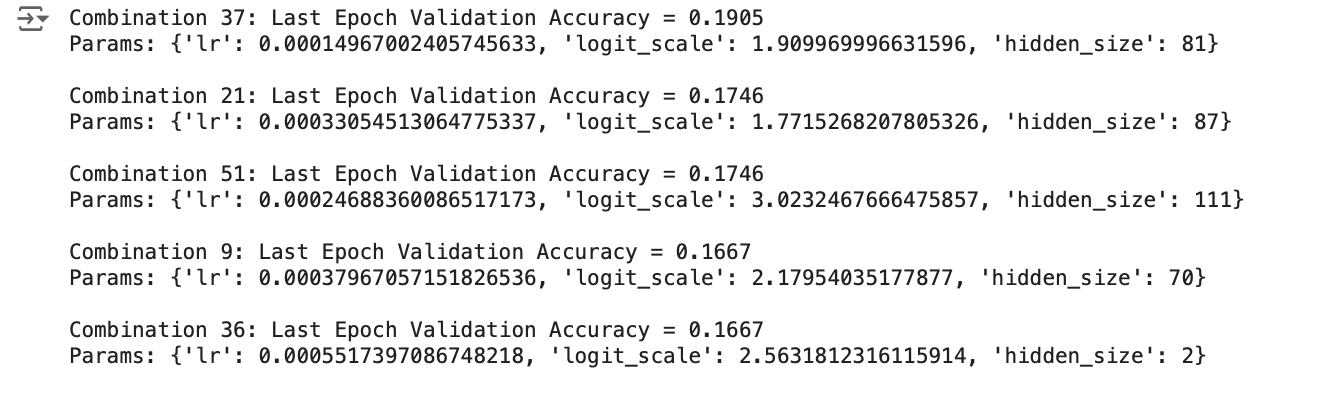

### 파라미터 조합별 학습 그래프 확인

In [ ]:
import matplotlib.pyplot as plt

def plot_accuracy_loss(comb_results):
    # comb_results: 각 파라미터 조합에 대한 학습 결과와 사용된 파라미터들을 포함한 딕셔너리

    for idx, result in comb_results.items():
        # idx: 현재 파라미터 조합의 인덱스
        # result: 해당 인덱스의 학습 결과와 파라미터들을 포함하는 딕셔너리

        train_losses = result["results"][0]  # 현재 조합의 학습 손실 리스트
        train_accuracy = result["results"][1]  # 현재 조합의 학습 정확도
        val_losses = result["results"][2]  # 현재 조합의 검증 손실 리스트
        val_accuracy = result["results"][3]  # 현재 조합의 검증 정확도
        params = result["params"]  # 현재 조합에 사용된 파라미터들

        # 설정한 파라미터 조합을 그래프의 제목으로 표시
        title = f"Combination {idx}: LR={params['lr']:.6f}, Logit Scale={params['logit_scale']:.2f}, Hidden Size={params['hidden_size']}"

        # 그래프를 그리기 위한 subplot을 생성
        fig, ax1 = plt.subplots()

        ax1.set_xlabel('Epoch')  # x축 레이블을 'Epoch'으로 설정
        ax1.set_ylabel('Loss')  # 왼쪽 y축 레이블을 'Loss'로 설정
        # 학습 손실을 파란색 실선으로 그림
        ax1.plot(train_losses, label='Train Loss', color='tab:blue')
        # 검증 손실을 주황색 실선으로 그림
        ax1.plot(val_losses, label='Validation Loss', color='tab:orange')
        ax1.tick_params(axis='y')  # 왼쪽 y축에 대한 눈금을 설정

        # 오른쪽 y축을 생성하여 정확도를 표시
        ax2 = ax1.twinx()
        ax2.set_ylabel('Accuracy')  # 오른쪽 y축 레이블을 'Accuracy'로 설정
        # 학습 정확도를 초록색 점선으로 그림
        ax2.plot([train_accuracy] * len(train_losses), label='Train Accuracy', color='tab:green', linestyle='dashed')
        # 검증 정확도를 빨간색 점선으로 그림
        ax2.plot([val_accuracy] * len(val_losses), label='Validation Accuracy', color='tab:red', linestyle='dashed')
        ax2.tick_params(axis='y')  # 오른쪽 y축에 대한 눈금을 설정

        # 그래프의 레이아웃을 자동으로 맞춤
        fig.tight_layout()
        plt.title(title)  # 그래프의 제목을 설정
        ax1.legend(loc='upper left')  # 왼쪽


In [ ]:
# top-5 최적 파라미터 조합만 확인하고자 함
subset_comb_results = {k: comb_results[k] for k in (37, 21, 51, 9, 36)}

In [ ]:
plot_accuracy_loss(subset_comb_results)

In [ ]:
import matplotlib.pyplot as plt

def plot_params_vs_accuracy(comb_results):
    # Extract parameters and validation accuracies
    lrs = []
    logit_scales = []
    hidden_sizes = []
    val_accuracies = []

    for idx, result in comb_results.items():
        params = result["params"]
        val_accuracy = result["results"][3]  # Assuming val_accuracy is a list, choose the last epoch accuracy.

        lrs.append(params["lr"])
        logit_scales.append(params["logit_scale"])
        hidden_sizes.append(params["hidden_size"])
        val_accuracies.append(val_accuracy)  # Using the last validation accuracy

    max_idx = val_accuracies.index(max(val_accuracies))
    best_lr = lrs[max_idx]
    best_logit_scale = logit_scales[max_idx]
    best_hidden_size = hidden_sizes[max_idx]

    print(f"Best Learning Rate: {best_lr} with Validation Accuracy: {max(val_accuracies):.4f}")
    print(f"Best Logit Scale: {best_logit_scale} with Validation Accuracy: {max(val_accuracies):.4f}")
    print(f"Best Hidden Size: {best_hidden_size} with Validation Accuracy: {max(val_accuracies):.4f}")

    # Plotting
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    # Plot 1: Learning Rate vs Validation Accuracy
    axes[0].scatter(lrs, val_accuracies, c='b', label='Validation Accuracy')
    axes[0].set_xlabel('Learning Rate')
    axes[0].set_ylabel('Validation Accuracy')
    axes[0].set_title('Learning Rate vs Validation Accuracy')
    axes[0].legend()

    # Plot 2: Logit Scale vs Validation Accuracy
    axes[1].scatter(logit_scales, val_accuracies, c='r', label='Validation Accuracy')
    axes[1].set_xlabel('Logit Scale')
    axes[1].set_ylabel('Validation Accuracy')
    axes[1].set_title('Logit Scale vs Validation Accuracy')
    axes[1].legend()

    # Plot 3: Hidden Size vs Validation Accuracy
    axes[2].scatter(hidden_sizes, val_accuracies, c='g', label='Validation Accuracy')
    axes[2].set_xlabel('Hidden Size')
    axes[2].set_ylabel('Validation Accuracy')
    axes[2].set_title('Hidden Size vs Validation Accuracy')
    axes[2].legend()

    plt.tight_layout()
    plt.show()

plot_params_vs_accuracy(comb_results)

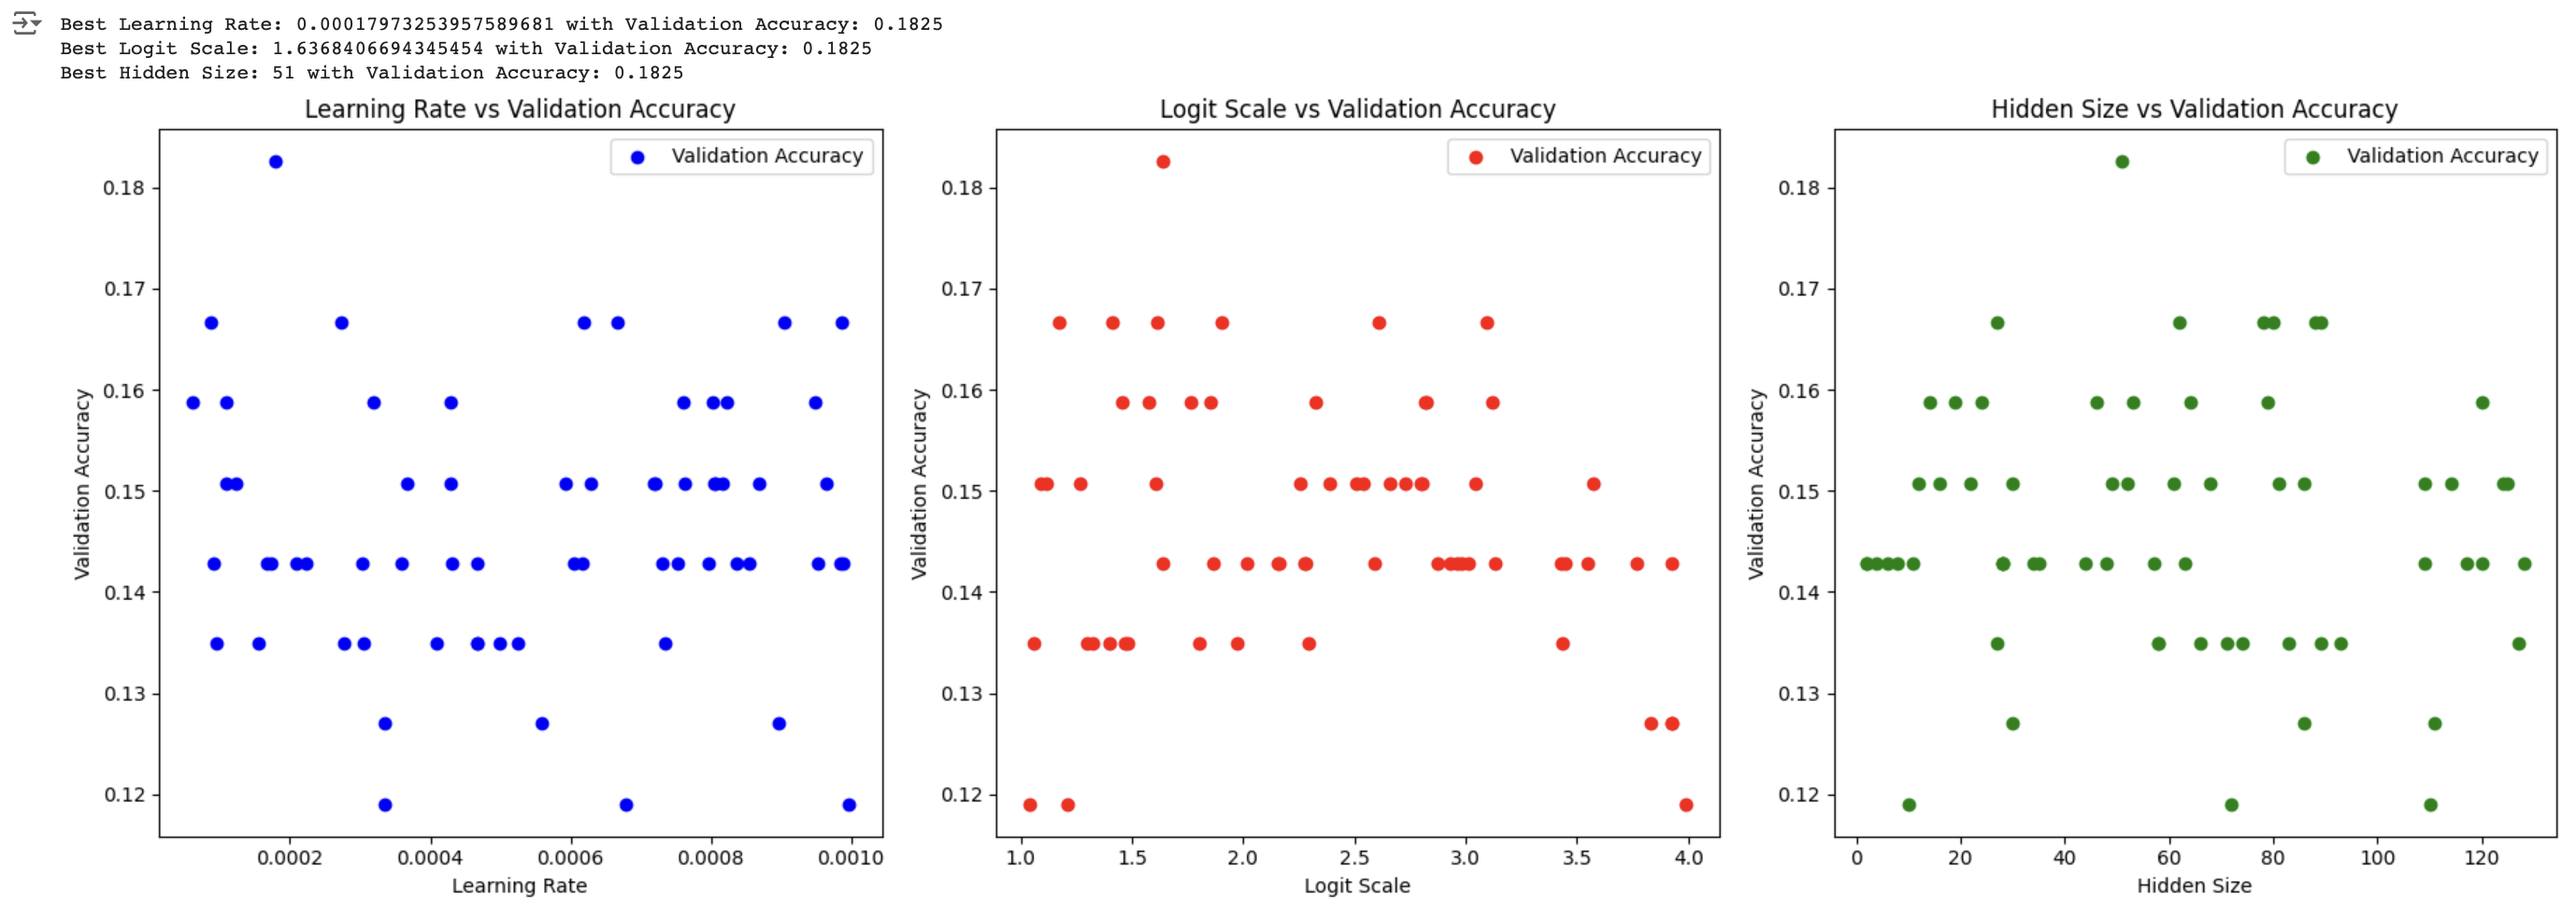

## 5.1. Using Ray Tune

In [ ]:
!pip install torchvision

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl.metadata (1.8 kB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinu

In [ ]:
!pip install ray[tune]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 MB 7.3 MB/s eta 0:00:00


In [ ]:
!pip install transformers

In [ ]:
from ray import tune
from ray.tune import CLIReporter
from ray.tune.schedulers import ASHAScheduler
import matplotlib.pyplot as plt

### 1. 직접 정의해보기

In [ ]:
from functools import partial
import os
import tempfile
from pathlib import Path
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import random_split
import torchvision
import torchvision.transforms as transforms
from ray import tune
from ray import train
from ray.train import Checkpoint, get_checkpoint
from ray.tune.schedulers import ASHAScheduler
import ray.cloudpickle as pickle

In [ ]:
def train_cifar(config, data_dir = None):
    net = VisionTextModel(
        vit_model,
        kobert_model,
        config["visual_projection_dim"],
        config["logit_scale"],
        text_projection_dim=7
      )

    device = "cpu"
    if torch.cuda.is_available():
        device = "cuda:0"
        if torch.cuda.device_count() > 1:
            net = nn.DataParallel(net)
    net.to(device)

    criterion = ContrastiveLoss()
    optimizer = optim.Adam(net.parameters(), lr=config["lr"])

    # 체크포인트 로드
    checkpoint = get_checkpoint()
    if checkpoint:
        with checkpoint.as_directory() as checkpoint_dir:
            data_path = Path(checkpoint_dir) / "data.pkl"
            with open(data_path, "rb") as fp:
                checkpoint_state = pickle.load(fp)
            start_epoch = checkpoint_state["epoch"]
            net.load_state_dict(checkpoint_state["net_state_dict"])
            optimizer.load_state_dict(checkpoint_state["optimizer_state_dict"])
    else:
        start_epoch = 0

    # train_loader = DataLoader(train_dataset, batch_size=int(config["batch_size"]), shuffle=True)
    # val_loader = DataLoader(val_dataset, batch_size=int(config["batch_size"]), shuffle=False)
    small_train_loader = sampler_loader(small_train_dataset, batch_size=int(config["batch_size"]))
    small_val_loader = sampler_loader(small_val_dataset, batch_size=int(config["batch_size"]))


    for epoch in range(10):
        net.train()
        running_loss = 0.0
        correct = 0
        total = 0
        epoch_steps = 0 # epoch_steps 초기화

        for images, labels in small_train_loader:
            images = images.to(device)
            texts = [generate_sentence(label) for label in labels]
            text_tokens = kobert_tokenizer(texts, padding=True, return_tensors="pt").to(device)

            optimizer.zero_grad()

            outputs = net(images, text_tokens)
            loss = criterion(outputs)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * labels.size(0)
            _, predicted_labels = torch.max(outputs, dim=1)
            correct += (predicted_labels == torch.arange(len(outputs)).to(device)).sum().item()
            total += labels.size(0)
            epoch_steps += 1

        val_loss = 0.0
        val_correct = 0
        val_total = 0
        val_steps = 0 # val_steps 초기화

        net.eval()
        with torch.no_grad():
            for images, labels in small_val_loader:
                images = images.to(device)
                texts = [generate_sentence(label) for label in labels]
                text_tokens = kobert_tokenizer(texts, padding=True, return_tensors="pt").to(device)

                outputs = net(images, text_tokens)
                _, predicted_labels = torch.max(outputs, dim=1)
                val_correct += (predicted_labels == torch.arange(len(outputs)).to(device)).sum().item()
                val_total += labels.size(0)

                loss = criterion(outputs)
                val_loss += loss.item() * labels.size(0)
                val_steps += 1

        # 체크포인트 저장
        checkpoint_data = {
            "epoch": epoch + 1,  # 다음 에폭을 시작할 수 있도록 +1
            "net_state_dict": net.state_dict(),
            "optimizer_state_dict": optimizer.state_dict(),
        }
        with tempfile.TemporaryDirectory() as checkpoint_dir:
            data_path = Path(checkpoint_dir) / "data.pkl"
            with open(data_path, "wb") as fp:
                pickle.dump(checkpoint_data, fp)

            checkpoint = Checkpoint.from_directory(checkpoint_dir)
            tune.report({"loss": val_loss / val_steps, "accuracy": val_correct / val_total},
                        checkpoint=checkpoint)

    print("Finished Training")


In [ ]:
config = {
  "lr": tune.loguniform(1e-5, 1e-3),  # 학습률(Learning Rate)을 1e-5에서 1e-3 사이의 로그 스케일에서 무작위로 샘플링
  "logit_scale": tune.uniform(0.1, 2.0),  # Logit Scale을 0.1에서 2.0 사이의 선형 스케일에서 무작위로 샘플링
  "visual_projection_dim": tune.choice([7, 128, 512])
}

In [ ]:
def main(num_samples=10, max_num_epochs=10, gpus_per_trial=2):
    # 하이퍼파라미터 설정 (튜닝할 파라미터들)
    config = {
        "visual_projection_dim": tune.choice([7, 128, 512]),  # 시각 모델의 투영 차원
        "logit_scale": tune.uniform(0.1, 2.0),  # 로짓 스케일
        "lr": tune.loguniform(1e-5, 1e-3),  # 학습률(Learning Rate)
        "batch_size": tune.choice([2, 4, 8, 16]),  # 배치 크기
    }

    # ASHA 스케줄러 설정
    scheduler = ASHAScheduler(
        metric="loss",  # 손실 값을 최소화하는 방향으로 튜닝
        mode="min",
        max_t=max_num_epochs,  # 최대 에폭 수
        grace_period=1,  # 초기 에폭 동안 중단되지 않도록 함
        reduction_factor=2,  # 리소스 축소 요인
    )

    # 튜닝 실행
    result = tune.run(
        partial(train_cifar),  # train_cifar 함수를 실행
        resources_per_trial={"cpu": 2, "gpu": gpus_per_trial},  # 각 실험에 할당할 자원 설정
        config=config,  # 하이퍼파라미터 구성
        num_samples=num_samples,  # 샘플링할 하이퍼파라미터 조합 수
        scheduler=scheduler,  # ASHA 스케줄러 사용
    )

    # 최적의 실험 결과를 찾고 출력
    best_trial = result.get_best_trial("loss", "min", "last")
    print(f"Best trial config: {best_trial.config}")
    print(f"Best trial final validation loss: {best_trial.last_result['loss']}")
    print(f"Best trial final validation accuracy: {best_trial.last_result['accuracy']}")

    # 최적의 하이퍼파라미터로 모델을 다시 생성
    best_trained_model = VisionTextModel(
        vit_model,
        kobert_model,
        best_trial.config["visual_projection_dim"],  # 최적의 투영 차원 사용
        text_projection_dim=7,  # 고정된 텍스트 투영 차원
        logit_scale=best_trial.config["logit_scale"]  # 최적의 로짓 스케일 사용
    )

    # 모델을 적절한 장치에 할당 (CPU 또는 GPU)
    device = "cpu"
    if torch.cuda.is_available():
        device = "cuda:0"
        if gpus_per_trial > 1:
            best_trained_model = nn.DataParallel(best_trained_model)
    best_trained_model.to(device)

    # 최적의 실험 체크포인트를 로드하여 모델에 적용
    best_checkpoint = result.get_best_checkpoint(trial=best_trial, metric="accuracy", mode="max")
    with best_checkpoint.as_directory() as checkpoint_dir:
        data_path = Path(checkpoint_dir) / "data.pkl"
        with open(data_path, "rb") as fp:
            best_checkpoint_data = pickle.load(fp)

        # 모델 상태를 로드
        best_trained_model.load_state_dict(best_checkpoint_data["net_state_dict"])

        # 테스트 세트에서 최종 성능 평가
        test_acc = test_accuracy(best_trained_model, device)
        print("Best trial test set accuracy: {}".format(test_acc))

if __name__ == "__main__":
    # 매 실험당 사용할 GPU 수를 여기에서 변경할 수 있습니다:
    main(num_samples=10, max_num_epochs=10, gpus_per_trial=2)


### 2. 학습 함수 및 데이터가 너무 커서 에러 -> 'use tune.with_parameters()'

In [ ]:
import ray
from ray import tune

# 모델과 데이터셋을 Ray 객체 스토어에 저장
vit_model_ref = ray.put(vit_model)
kobert_model_ref = ray.put(kobert_model)
train_dataset_ref = ray.put(train_dataset)
val_dataset_ref = ray.put(val_dataset)

def train_cifar(config, vit_model_ref=None, kobert_model_ref=None, train_dataset_ref=None, val_dataset_ref=None):
    # Ray 객체 스토어에서 모델과 데이터셋 가져오기
    vit_model = ray.get(vit_model_ref)
    kobert_model = ray.get(kobert_model_ref)
    train_dataset = ray.get(train_dataset_ref)
    val_dataset = ray.get(val_dataset_ref)

    net = VisionTextModel(
        vit_model,
        kobert_model,
        config["visual_projection_dim"],
        config["logit_scale"],
        text_projection_dim=7
    )

    device = "cpu"
    if torch.cuda.is_available():
        device = "cuda:0"
        if torch.cuda.device_count() > 1:
            net = nn.DataParallel(net)
    net.to(device)

    criterion = ContrastiveLoss()
    optimizer = optim.Adam(net.parameters(), lr=config["lr"])

    train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False)

    for epoch in range(10):
        net.train()
        running_loss = 0.0
        correct = 0
        total = 0
        epoch_steps = 0

        for images, labels in train_loader:
            images = images.to(device)
            texts = [generate_sentence(label) for label in labels]
            text_tokens = kobert_tokenizer(texts, padding=True, return_tensors="pt").to(device)

            optimizer.zero_grad()

            outputs = net(images, text_tokens)
            loss = criterion(outputs)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * labels.size(0)
            _, predicted_labels = torch.max(outputs, dim=1)
            correct += (predicted_labels == torch.arange(len(outputs)).to(device)).sum().item()
            total += labels.size(0)
            epoch_steps += 1

        val_loss = 0.0
        val_correct = 0
        val_total = 0
        val_steps = 0

        net.eval()
        with torch.no_grad():
            for images, labels in val_loader:
                images = images.to(device)
                texts = [generate_sentence(label) for label in labels]
                text_tokens = kobert_tokenizer(texts, padding=True, return_tensors="pt").to(device)

                outputs = net(images, text_tokens)
                _, predicted_labels = torch.max(outputs, dim=1)
                val_correct += (predicted_labels == torch.arange(len(outputs)).to(device)).sum().item()
                val_total += labels.size(0)

                loss = criterion(outputs)
                val_loss += loss.item() * labels.size(0)
                val_steps += 1

        tune.report({"loss": val_loss / val_steps, "accuracy": val_correct / val_total})

        net.train()


/usr/lib/python3.10/subprocess.py:1796: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _posixsubprocess.fork_exec(
/usr/lib/python3.10/subprocess.py:1796: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _posixsubprocess.fork_exec(
2024-08-24 12:13:47,781	INFO worker.py:1781 -- Started a local Ray instance.


In [ ]:
import ray

# Ray를 로컬 모드로 초기화합니다.
ray.init(local_mode=True, ignore_reinit_error=True)

2024-08-24 10:38:58,236	INFO worker.py:1614 -- Calling ray.init() again after it has already been called.


Python version:,3.10.12
Ray version:,2.34.0


In [ ]:
def main(num_samples=10, max_num_epochs=10, gpus_per_trial=1):
    config = {
        "visual_projection_dim": tune.choice([7, 128]),
        "logit_scale": tune.uniform(0.1, 2.0),
        "lr": tune.loguniform(1e-5, 1e-3)
    }

    scheduler = ASHAScheduler(
        metric="loss",
        mode="min",
        max_t=max_num_epochs,
        grace_period=1,
        reduction_factor=2,
    )

    result = tune.run(
        tune.with_parameters(
            train_cifar,
            vit_model_ref=vit_model_ref,
            kobert_model_ref=kobert_model_ref,
            train_dataset_ref=train_dataset_ref,
            val_dataset_ref=val_dataset_ref
        ),
        resources_per_trial={"cpu": 2, "gpu": gpus_per_trial},
        config=config,
        num_samples=num_samples,
        scheduler=scheduler,
    )

    best_trial = result.get_best_trial("loss", "min", "last")
    print(f"Best trial config: {best_trial.config}")
    print(f"Best trial final validation loss: {best_trial.last_result['loss']}")
    print(f"Best trial final validation accuracy: {best_trial.last_result['accuracy']}")

    best_trained_model = VisionTextModel(
        vit_model,
        kobert_model,
        best_trial.config["visual_projection_dim"],
        text_projection_dim=7,
        logit_scale=best_trial.config["logit_scale"]
    )

    device = "cpu"
    if torch.cuda.is_available():
        device = "cuda:0"
        if gpus_per_trial > 1:
            best_trained_model = nn.DataParallel(best_trained_model)
    best_trained_model.to(device)

    best_checkpoint = result.get_best_checkpoint(trial=best_trial, metric="accuracy", mode="max")
    with best_checkpoint.as_directory() as checkpoint_dir:
        data_path = Path(checkpoint_dir) / "data.pkl"
        with open(data_path, "rb") as fp:
            best_checkpoint_data = pickle.load(fp)

        best_trained_model.load_state_dict(best_checkpoint_data["net_state_dict"])

        test_acc = test_accuracy(best_trained_model, device)
        print("Best trial test set accuracy: {}".format(test_acc))

if __name__ == "__main__":
    main(num_samples=10, max_num_epochs=10, gpus_per_trial=1)

+--------------------------------------------------------------------+
| Configuration for experiment     train_cifar_2024-08-24_12-14-06   |
+--------------------------------------------------------------------+
| Search algorithm                 BasicVariantGenerator             |
| Scheduler                        AsyncHyperBandScheduler           |
| Number of trials                 10                                |
+--------------------------------------------------------------------+

View detailed results here: /root/ray_results/train_cifar_2024-08-24_12-14-06
To visualize your results with TensorBoard, run: `tensorboard --logdir /tmp/ray/session_2024-08-24_12-13-46_225445_2992/artifacts/2024-08-24_12-14-06/train_cifar_2024-08-24_12-14-06/driver_artifacts`

Trial status: 10 PENDING
Current time: 2024-08-24 12:14:06. Total running time: 0s
Logical resource usage: 2.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
+-----------------------------------------------------------

2024-08-24 12:14:09,445	ERROR tune_controller.py:1331 -- Trial task failed for trial train_cifar_5bc46_00000
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/ray/air/execution/_internal/event_manager.py", line 110, in resolve_future
    result = ray.get(future)
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/client_mode_hook.py", line 103, in wrapper
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/worker.py", line 2659, in get
    values, debugger_breakpoint = worker.get_objects(object_refs, timeout=timeout)
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/worker.py", line 873, in get_objects
    raise value
ray.exceptions.ActorDiedError: The actor died unexpectedly before finishing this task.
	class_name: ImplicitFunc
	actor_id: c3d12d48f10d6

(raylet) Traceback (most recent call last):
  File "python/ray/_raylet.pyx", line 1852, in ray._raylet.execute_task
  File "python/ray/_raylet.pyx", line 1953, in ray._raylet.execute_task
  File "python/ray/_raylet.pyx", line 1858, in ray._raylet.execute_task
  File "python/ray/_raylet.pyx", line 1799, in ray._raylet.execute_task.function_executor
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/function_manager.py", line 691, in actor_method_executor
    return method(__ray_actor, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/function_manager.py", line 603, in temporary_actor_method
    raise RuntimeError(
RuntimeError: The actor with name ImplicitFunc failed to import on the worker. This may be because needed library dependencies are not installed in the worker environment:

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/function_manager.py", line 642, in _load_actor_class_from_gcs
    actor_

2024-08-24 12:14:13,120	ERROR tune_controller.py:1331 -- Trial task failed for trial train_cifar_5bc46_00001
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/ray/air/execution/_internal/event_manager.py", line 110, in resolve_future
    result = ray.get(future)
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/client_mode_hook.py", line 103, in wrapper
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/worker.py", line 2659, in get
    values, debugger_breakpoint = worker.get_objects(object_refs, timeout=timeout)
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/worker.py", line 873, in get_objects
    raise value
ray.exceptions.ActorDiedError: The actor died unexpectedly before finishing this task.
	class_name: ImplicitFunc
	actor_id: ad4e90e14fe13


Trial train_cifar_5bc46_00001 errored after 0 iterations at 2024-08-24 12:14:13. Total running time: 6s
Error file: /tmp/ray/session_2024-08-24_12-13-46_225445_2992/artifacts/2024-08-24_12-14-06/train_cifar_2024-08-24_12-14-06/driver_artifacts/train_cifar_5bc46_00001_1_logit_scale=1.3359,lr=0.0005,visual_projection_dim=128_2024-08-24_12-14-06/error.txt


2024-08-24 12:14:16,088	ERROR tune_controller.py:1331 -- Trial task failed for trial train_cifar_5bc46_00002
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/ray/air/execution/_internal/event_manager.py", line 110, in resolve_future
    result = ray.get(future)
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/client_mode_hook.py", line 103, in wrapper
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/worker.py", line 2659, in get
    values, debugger_breakpoint = worker.get_objects(object_refs, timeout=timeout)
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/worker.py", line 873, in get_objects
    raise value
ray.exceptions.ActorDiedError: The actor died unexpectedly before finishing this task.
	class_name: ImplicitFunc
	actor_id: ec9e359ac1d60

(raylet) Traceback (most recent call last):
  File "python/ray/_raylet.pyx", line 1852, in ray._raylet.execute_task
  File "python/ray/_raylet.pyx", line 1953, in ray._raylet.execute_task
  File "python/ray/_raylet.pyx", line 1858, in ray._raylet.execute_task
  File "python/ray/_raylet.pyx", line 1799, in ray._raylet.execute_task.function_executor
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/function_manager.py", line 691, in actor_method_executor
    return method(__ray_actor, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/function_manager.py", line 603, in temporary_actor_method
    raise RuntimeError(
RuntimeError: The actor with name ImplicitFunc failed to import on the worker. This may be because needed library dependencies are not installed in the worker environment:

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/function_manager.py", line 642, in _load_actor_class_from_gcs
    actor_

2024-08-24 12:14:19,104	ERROR tune_controller.py:1331 -- Trial task failed for trial train_cifar_5bc46_00003
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/ray/air/execution/_internal/event_manager.py", line 110, in resolve_future
    result = ray.get(future)
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/client_mode_hook.py", line 103, in wrapper
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/worker.py", line 2659, in get
    values, debugger_breakpoint = worker.get_objects(object_refs, timeout=timeout)
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/worker.py", line 873, in get_objects
    raise value
ray.exceptions.ActorDiedError: The actor died unexpectedly before finishing this task.
	class_name: ImplicitFunc
	actor_id: 8f7a43b8dd7bf


Trial train_cifar_5bc46_00003 errored after 0 iterations at 2024-08-24 12:14:19. Total running time: 12s
Error file: /tmp/ray/session_2024-08-24_12-13-46_225445_2992/artifacts/2024-08-24_12-14-06/train_cifar_2024-08-24_12-14-06/driver_artifacts/train_cifar_5bc46_00003_3_logit_scale=0.3652,lr=0.0000,visual_projection_dim=7_2024-08-24_12-14-06/error.txt


2024-08-24 12:14:22,128	ERROR tune_controller.py:1331 -- Trial task failed for trial train_cifar_5bc46_00004
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/ray/air/execution/_internal/event_manager.py", line 110, in resolve_future
    result = ray.get(future)
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/client_mode_hook.py", line 103, in wrapper
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/worker.py", line 2659, in get
    values, debugger_breakpoint = worker.get_objects(object_refs, timeout=timeout)
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/worker.py", line 873, in get_objects
    raise value
ray.exceptions.ActorDiedError: The actor died unexpectedly before finishing this task.
	class_name: ImplicitFunc
	actor_id: 86c25cd3f992e

(raylet) Traceback (most recent call last):
  File "python/ray/_raylet.pyx", line 1852, in ray._raylet.execute_task
  File "python/ray/_raylet.pyx", line 1953, in ray._raylet.execute_task
  File "python/ray/_raylet.pyx", line 1858, in ray._raylet.execute_task
  File "python/ray/_raylet.pyx", line 1799, in ray._raylet.execute_task.function_executor
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/function_manager.py", line 691, in actor_method_executor
    return method(__ray_actor, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/function_manager.py", line 603, in temporary_actor_method
    raise RuntimeError(
RuntimeError: The actor with name ImplicitFunc failed to import on the worker. This may be because needed library dependencies are not installed in the worker environment:

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/function_manager.py", line 642, in _load_actor_class_from_gcs
    actor_

2024-08-24 12:14:25,082	ERROR tune_controller.py:1331 -- Trial task failed for trial train_cifar_5bc46_00005
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/ray/air/execution/_internal/event_manager.py", line 110, in resolve_future
    result = ray.get(future)
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/client_mode_hook.py", line 103, in wrapper
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/worker.py", line 2659, in get
    values, debugger_breakpoint = worker.get_objects(object_refs, timeout=timeout)
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/worker.py", line 873, in get_objects
    raise value
ray.exceptions.ActorDiedError: The actor died unexpectedly before finishing this task.
	class_name: ImplicitFunc
	actor_id: 05ffd649677a9


Trial train_cifar_5bc46_00005 errored after 0 iterations at 2024-08-24 12:14:25. Total running time: 18s
Error file: /tmp/ray/session_2024-08-24_12-13-46_225445_2992/artifacts/2024-08-24_12-14-06/train_cifar_2024-08-24_12-14-06/driver_artifacts/train_cifar_5bc46_00005_5_logit_scale=0.9606,lr=0.0000,visual_projection_dim=7_2024-08-24_12-14-06/error.txt


2024-08-24 12:14:28,114	ERROR tune_controller.py:1331 -- Trial task failed for trial train_cifar_5bc46_00006
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/ray/air/execution/_internal/event_manager.py", line 110, in resolve_future
    result = ray.get(future)
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/client_mode_hook.py", line 103, in wrapper
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/worker.py", line 2659, in get
    values, debugger_breakpoint = worker.get_objects(object_refs, timeout=timeout)
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/worker.py", line 873, in get_objects
    raise value
ray.exceptions.ActorDiedError: The actor died unexpectedly before finishing this task.
	class_name: ImplicitFunc
	actor_id: 1494d073e60da

(raylet) Traceback (most recent call last):
  File "python/ray/_raylet.pyx", line 1852, in ray._raylet.execute_task
  File "python/ray/_raylet.pyx", line 1953, in ray._raylet.execute_task
  File "python/ray/_raylet.pyx", line 1858, in ray._raylet.execute_task
  File "python/ray/_raylet.pyx", line 1799, in ray._raylet.execute_task.function_executor
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/function_manager.py", line 691, in actor_method_executor
    return method(__ray_actor, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/function_manager.py", line 603, in temporary_actor_method
    raise RuntimeError(
RuntimeError: The actor with name ImplicitFunc failed to import on the worker. This may be because needed library dependencies are not installed in the worker environment:

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/function_manager.py", line 642, in _load_actor_class_from_gcs
    actor_

2024-08-24 12:14:31,124	ERROR tune_controller.py:1331 -- Trial task failed for trial train_cifar_5bc46_00007
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/ray/air/execution/_internal/event_manager.py", line 110, in resolve_future
    result = ray.get(future)
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/client_mode_hook.py", line 103, in wrapper
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/worker.py", line 2659, in get
    values, debugger_breakpoint = worker.get_objects(object_refs, timeout=timeout)
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/worker.py", line 873, in get_objects
    raise value
ray.exceptions.ActorDiedError: The actor died unexpectedly before finishing this task.
	class_name: ImplicitFunc
	actor_id: 528808b7fdabe


Trial train_cifar_5bc46_00007 errored after 0 iterations at 2024-08-24 12:14:31. Total running time: 24s
Error file: /tmp/ray/session_2024-08-24_12-13-46_225445_2992/artifacts/2024-08-24_12-14-06/train_cifar_2024-08-24_12-14-06/driver_artifacts/train_cifar_5bc46_00007_7_logit_scale=0.9504,lr=0.0001,visual_projection_dim=7_2024-08-24_12-14-06/error.txt


2024-08-24 12:14:34,082	ERROR tune_controller.py:1331 -- Trial task failed for trial train_cifar_5bc46_00008
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/ray/air/execution/_internal/event_manager.py", line 110, in resolve_future
    result = ray.get(future)
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/client_mode_hook.py", line 103, in wrapper
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/worker.py", line 2659, in get
    values, debugger_breakpoint = worker.get_objects(object_refs, timeout=timeout)
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/worker.py", line 873, in get_objects
    raise value
ray.exceptions.ActorDiedError: The actor died unexpectedly before finishing this task.
	class_name: ImplicitFunc
	actor_id: f874e82e35adc

(raylet) Traceback (most recent call last):
  File "python/ray/_raylet.pyx", line 1852, in ray._raylet.execute_task
  File "python/ray/_raylet.pyx", line 1953, in ray._raylet.execute_task
  File "python/ray/_raylet.pyx", line 1858, in ray._raylet.execute_task
  File "python/ray/_raylet.pyx", line 1799, in ray._raylet.execute_task.function_executor
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/function_manager.py", line 691, in actor_method_executor
    return method(__ray_actor, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/function_manager.py", line 603, in temporary_actor_method
    raise RuntimeError(
RuntimeError: The actor with name ImplicitFunc failed to import on the worker. This may be because needed library dependencies are not installed in the worker environment:

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/function_manager.py", line 642, in _load_actor_class_from_gcs
    actor_

2024-08-24 12:14:37,098	ERROR tune_controller.py:1331 -- Trial task failed for trial train_cifar_5bc46_00009
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/ray/air/execution/_internal/event_manager.py", line 110, in resolve_future
    result = ray.get(future)
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/client_mode_hook.py", line 103, in wrapper
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/worker.py", line 2659, in get
    values, debugger_breakpoint = worker.get_objects(object_refs, timeout=timeout)
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/worker.py", line 873, in get_objects
    raise value
ray.exceptions.ActorDiedError: The actor died unexpectedly before finishing this task.
	class_name: ImplicitFunc
	actor_id: d768c01ccaea0


Trial train_cifar_5bc46_00009 errored after 0 iterations at 2024-08-24 12:14:37. Total running time: 30s
Error file: /tmp/ray/session_2024-08-24_12-13-46_225445_2992/artifacts/2024-08-24_12-14-06/train_cifar_2024-08-24_12-14-06/driver_artifacts/train_cifar_5bc46_00009_9_logit_scale=1.6012,lr=0.0000,visual_projection_dim=7_2024-08-24_12-14-06/error.txt

Trial status: 10 ERROR
Current time: 2024-08-24 12:14:37. Total running time: 30s
Logical resource usage: 0/12 CPUs, 0/1 GPUs (0.0/1.0 accelerator_type:A100)
+-------------------------------------------------------------------------------------------+
| Trial name                status       ...al_projection_dim     logit_scale            lr |
+-------------------------------------------------------------------------------------------+
| train_cifar_5bc46_00000   ERROR                         128        0.807396   1.47407e-05 |
| train_cifar_5bc46_00001   ERROR                         128        1.33589    0.000539544 |
| train_cifar_5b

TuneError: ('Trials did not complete', [train_cifar_5bc46_00000, train_cifar_5bc46_00001, train_cifar_5bc46_00002, train_cifar_5bc46_00003, train_cifar_5bc46_00004, train_cifar_5bc46_00005, train_cifar_5bc46_00006, train_cifar_5bc46_00007, train_cifar_5bc46_00008, train_cifar_5bc46_00009])

### 3. 모델 파라미터 고정 ver

In [ ]:
# KoBERT와 ViT 모델의 파라미터 고정
for param in vit_model.parameters():
    param.requires_grad = False

for param in kobert_model.parameters():
    param.requires_grad = False

In [ ]:
# 모델의 파라미터를 고정한 상태에서 학습 함수 정의
def train_clip_model(config):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # VisionTextModel을 초기화할 때 고정된 모델을 사용
    model = VisionTextModel(
        vit_model, kobert_model,
        visual_projection_dim=config["projection_dim"],
        text_projection_dim=config["projection_dim"],
        logit_scale=config["logit_scale"]
    ).to(device)

    optimizer = optim.Adam(model.parameters(), lr=config["lr"])
    criterion = ContrastiveLoss()

    for epoch in range(10):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for images, labels in small_train_loader:
            images = images.to(device)
            texts = [generate_sentence(label) for label in labels]
            text_tokens = kobert_tokenizer(texts, padding=True, return_tensors="pt").to(device)

            optimizer.zero_grad()
            outputs = model(images, text_tokens)
            loss = criterion(outputs)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * labels.size(0)
            _, predicted_labels = torch.max(outputs, dim=1)
            correct += (predicted_labels == torch.arange(len(outputs)).to(device)).sum().item()
            total += labels.size(0)

        val_loss = 0.0
        val_correct = 0
        val_total = 0
        with torch.no_grad():
            model.eval()
            for images, labels in small_val_loader:
                images = images.to(device)
                texts = [generate_sentence(label) for label in labels]
                text_tokens = kobert_tokenizer(texts, padding=True, return_tensors="pt").to(device)

                outputs = model(images, text_tokens)
                loss = criterion(outputs)
                val_loss += loss.item() * labels.size(0)
                _, predicted_labels = torch.max(outputs, dim=1)
                val_correct += (predicted_labels == torch.arange(len(outputs)).to(device)).sum().item()
                val_total += labels.size(0)

        tune.report(loss=val_loss, accuracy=val_correct / val_total)


# 6. Test

### 하이퍼파라미터 조합 중 인퍼런스를 가장 잘하는 조합 evaluation

In [ ]:
k = 5     # top-k accuracy

with torch.no_grad():
  for images, labels in test_loader:
      texts = [generate_sentence(label, dct=test_label_to_class) for label in torch.arange(len(test_emotions))]
      text_tokens = kobert_tokenizer(texts, padding=True, return_tensors="pt").to(device)
      outputs = model(images, text_tokens)        # N x 44 matrix

      max_k_preds = torch.topk(outputs, k, dim=1)[1]
      correct = max_k_preds.eq(labels.view(-1, 1).expand_as(max_k_preds))  # labels는 오름차순으로 배치
      top_k_acc = correct.float().sum(dim=1).mean().item()